<a href="https://colab.research.google.com/github/zZHugoZz/Machine-learning-Pytorch/blob/main/Fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo

In [3]:
import random
from pathlib import Path
from PIL import Image
from typing import Callable
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torchinfo import summary, ModelStatistics
import matplotlib.pyplot as plt
import numpy as np

# Seed and device

* setting the seed and the batch size
* setting the device to cuda if available

In [4]:
SEED = 5432
BATCH_SIZE = 32

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
root_path = Path("drive/MyDrive/Machine learning/Datasets/Fruit data")
train_path = root_path.joinpath("train")
test_path = root_path.joinpath("test")
predict_path = root_path / "predict"

transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(45),
    T.RandomInvert(0.2),
    T.RandomCrop((224, 224)),
    T.ColorJitter(0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
    # T.Normalize(mean=[20.7144, 18.0092, 13.6041], std=[6.9384, 7.3994, 8.1370])
])


class FruitDataset(Dataset):
    def __init__(
        self, train_path: Path, test_path: Path, predict_path: Path, tranform: Callable
    ) -> None:
        self.train_path = train_path
        self.test_path = test_path
        self.predict_path = predict_path
        self.transform = transform

        self.train_data = ImageFolder(str(train_path), self.transform)
        self.test_data = ImageFolder(str(test_path), self.transform)
        self.predict_images = self._process_predict_images(predict_path)

    def __getitem__(self) -> tuple[ImageFolder, ImageFolder, torch.Tensor]:
        return self.train_data, self.test_data, self.predict_images

    def __len__(self) -> int:
        return len(self.train_data) + len(self.test_data) + len(self.predict_images)

    def _process_predict_images(self, predict_path: Path) -> torch.Tensor:
        transform_predict = T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor()
        ])
        predict_images = list(predict_path.glob("*.jpeg"))
        predict_images = [transform_predict(read_image(str(image))) for image in predict_images]
        predict_images = [image for image in predict_images if image.shape == torch.Size([3, 224, 224])]
        return torch.stack(predict_images)

In [6]:
class Normalization:
    """
    Helper class to get the mean and std
    """

    def __init__(self, train_data: ImageFolder, test_data: ImageFolder) -> None:
        self.train_data = train_data
        self.test_data = test_data

    def get_stats(self) -> tuple[float, ...]:
        train_dataloader = DataLoader(self.train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
        test_dataloader = DataLoader(self.test_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
        train_mean, train_std = self._compute(train_dataloader, len(train_dataloader))
        test_mean, test_std = self._compute(test_dataloader, len(test_dataloader))
        return train_mean, train_std, test_mean, test_std

    def _compute(self, dataloader: DataLoader, samples: int) -> tuple[float, float]:
        mean = 0.0
        std = 0.0
        for images, _ in dataloader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= samples
        std /= samples
        return mean, std

In [7]:
fruit_dataset = FruitDataset(train_path, test_path, predict_path, transform)
train_data, test_data, predict_images = fruit_dataset.__getitem__()

def get_stats() -> None:
    normalization = Normalization(train_data, test_data)
    stats = normalization.get_stats()
    print(stats)

In [8]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

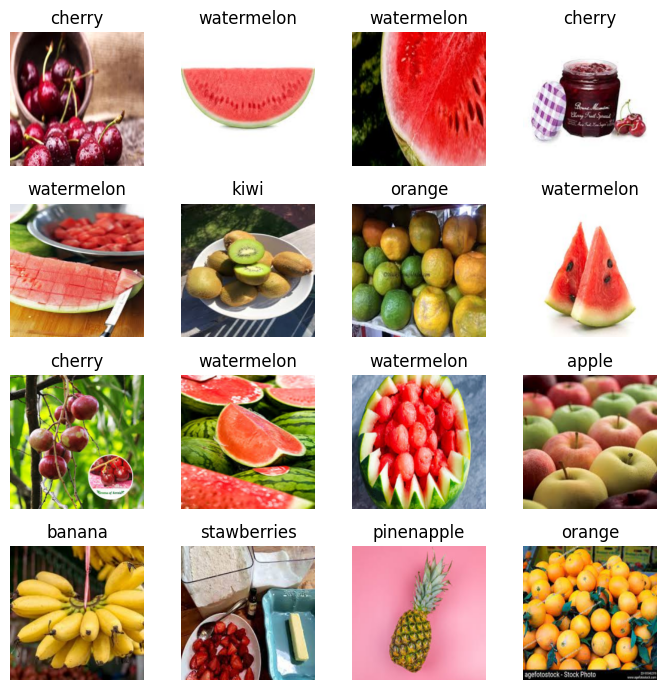

In [9]:
def plot_images(n_rows: int, n_cols: int, dataset: ImageFolder) -> None:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 7))

    for i, ax in enumerate(axs.flat):
        image, label = dataset[random.randint(0, len(dataset))]
        ax.imshow(image.permute(1, 2, 0))
        ax.axis("off")
        ax.set_title(dataset.classes[label])

    fig.tight_layout()
    fig.show()


plot_images(4, 4, ImageFolder(str(test_path), transform=T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])))

In [10]:
def plot_predictions(
    n_rows: int, n_cols: int, preds: torch.Tensor, images: torch.Tensor
) -> None:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis("off")
        ax.set_title(f"predicted: {train_data.classes[preds[i]]}")

    fig.tight_layout()
    fig.show()

In [11]:
class ModelPerformanceStats:
    def __init__(self, epoch_values: list) -> None:
        self.epoch_values = epoch_values
        self.fig, (self.loss_ax, self.acc_ax) = plt.subplots(1, 2, figsize=(10, 3))

    def plot_loss(self, train_loss_values: list, test_loss_values: list) -> None:
        self.loss_ax.plot(self.epoch_values, train_loss_values, label="train loss")
        self.loss_ax.plot(self.epoch_values, test_loss_values, label="test loss")
        self.loss_ax.set_title("Loss")
        self.loss_ax.grid()
        self.loss_ax.legend(loc="upper left")

    def plot_accuracy(self, train_acc_values: list, test_acc_values: list) -> None:
        self.acc_ax.plot(self.epoch_values, train_acc_values, label="train accuracy")
        self.acc_ax.plot(self.epoch_values, test_acc_values, label="test accuracy")
        self.acc_ax.set_title("Accuracy")
        self.acc_ax.grid()
        self.acc_ax.legend(loc="upper left")

    def show(self) -> None:
        self.fig.tight_layout()
        self.fig.show()

In [12]:
def get_summary(model: nn.Module, input_size: tuple) -> ModelStatistics:
    return summary(model, input_size)


def save_model(model_state_dict: object, path: str, model_file_name: str) -> None:
    file = f"{path}/{model_file_name}"
    torch.save(model_state_dict, file)

# Model

* Insted of creating a model from scratch, we pick an already trained model, such as ```resnet18``` in this case. We just modify it to fit our needs

* Then we get some info about the model using the helper function ```get_summary```

In [13]:
fruit_classifier = resnet18(weights=ResNet18_Weights.DEFAULT)
in_features = fruit_classifier.fc.in_features
fruit_classifier.fc = nn.Linear(in_features, 10)
get_summary(fruit_classifier, (32, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 251MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

# Training and testing

Down below is a class that contains three methods:
* ```train_step:``` trains the model
* ```test_step:``` tests the model with new data after each training step
* ```get_accuracy:``` small method to get the accuracy after each training and testing step



In [14]:
class TrainAndTest:
    def __init__(
        self,
        model: nn.Module,
        train_data: DataLoader,
        test_data: DataLoader,
        criterion: _Loss,
        optimizer: Optimizer,
        device: str,
        scheduler1: ReduceLROnPlateau | None = None,
        scheduler2 = None
    ) -> None:
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler1 = scheduler1
        self.scheduler2 = scheduler2

    def train_step(self) -> tuple[float, float]:
        train_loss = torch.tensor(0, dtype=torch.float32).to(device)
        train_acc = torch.tensor(0, dtype=torch.float32).to(device)

        self.model.train()
        for X, y in self.train_data:
            X, y = X.to(self.device), y.to(self.device)
            preds = self.model(X)

            loss = self.criterion(preds, y)
            acc = self.get_accuracy(torch.softmax(preds, dim=1).argmax(dim=1), y)
            train_loss += loss
            train_acc += acc

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.scheduler1 is not None:
            self.scheduler1.step(train_loss, epoch)
        if self.scheduler2 is not None:
            self.scheduler2.step()

        train_loss /= len(self.train_data)
        train_acc /= len(self.train_data)
        print(f"train loss: {train_loss:.5f} | train accuracy: {train_acc:.2f}%")
        return train_loss.item(), train_acc.item()

    def test_step(self) -> tuple[float, float]:
        test_loss = torch.tensor(0, dtype=torch.float32).to(device)
        test_acc = torch.tensor(0, dtype=torch.float32).to(device)

        self.model.eval()
        with torch.inference_mode():
            for X, y in self.test_data:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)

                loss = self.criterion(preds, y)
                acc = self.get_accuracy(torch.softmax(preds, dim=1).argmax(dim=1), y)
                test_loss += loss
                test_acc += acc

            test_loss /= len(self.test_data)
            test_acc /= len(self.test_data)
            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")
            return test_loss.item(), test_acc.item()

    def get_accuracy(self, preds: torch.Tensor, labels: torch.Tensor) -> float:
        equals = torch.eq(preds, labels).sum().item()
        acc = (equals / len(labels)) * 100
        return acc

# Training loop

* First we set up the **criterion**, the **optimizer** and the **scheduler**
* The 5 lists are to keep track of useful values that will be used for plots
* Then we instanciate the ```TrainAndTest``` class
* We append the useful values to the lists during the training loop
* We save the model's ```state_dict```
* And we plot the loss and accurayc for training and testing

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.001

total_steps = len(train_dataloader) * EPOCHS

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(fruit_classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = torch.optim.Adam(fruit_classifier.parameters(), lr=LEARNING_RATE)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, total_steps)

epoch_values = []
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

train_test = TrainAndTest(
    fruit_classifier,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    device,
    scheduler1,
    scheduler2
)

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}\n----------")
    train_loss, train_acc = train_test.train_step()
    test_loss, test_acc = train_test.test_step()

    epoch_values.append(epoch)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)

In [ ]:
save_model(
    fruit_classifier.state_dict(),
    "drive/MyDrive/Machine learning/Models",
    "fruit_classifier"
)

In [ ]:
plot_performances = ModelPerformanceStats(epoch_values)
plot_performances.plot_loss(train_loss_values, test_loss_values)
plot_performances.plot_accuracy(train_acc_values, test_acc_values)
plot_performances.show()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


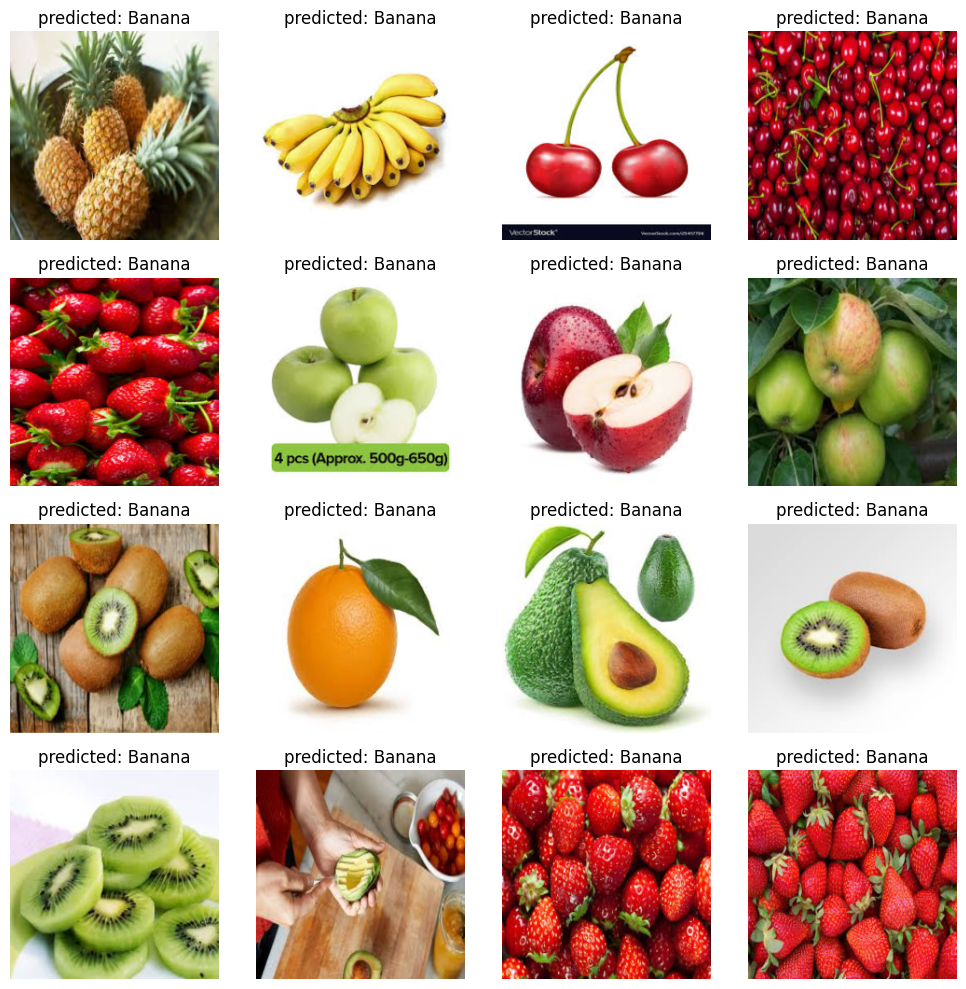

In [17]:
# weird results, will fix later
model_path = "drive/MyDrive/Machine learning/Models/fruit_classifier"
model = fruit_classifier
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
logits = model(predict_images.to(device))
preds = torch.softmax(logits, dim=1).argmax(dim=1)
preds.cpu()

plot_predictions(4, 4, preds, predict_images)